# Stock Market Prediction
***
## Table of Contents

***

In [201]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import date

## 1. Introduction


## 2. Device Agnostic Code
Mac GPU acceleration (`mps` backend) delivers significant speed-up over CPU for deep learning tasks, especially for large models and batch sizes. On Windows, `cuda` is used instead of `mps`.

However, during the training process, I encountered several issues with LSTM networks on the MPS backend (e.g., error metrics became substantially higher compared to the CPU, etc.). Therefore, the CPU will be used throughout this project for '*safety*'.

**Reference**:
- [Training results from using MPS backend are poor compared to CPU and CUDA](https://github.com/pytorch/pytorch/issues/109457)
- [MPS backend produces bad training results in comparison to other backends](https://github.com/pytorch/pytorch/issues/92615)
- [Memory Leak in MPS Backend During LSTM Iterations (Out of Memory Error)](https://github.com/pytorch/pytorch/issues/145374)

In [ ]:
# device = "cuda" if torch.cuda.is_available() else "cpu"  # For Windows
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  # For Mac
device = torch.device("cpu")  # For Mac, safer device use
device

device(type='cpu')

## 3. Loading Dataset
This project will use yfinance API to fetch financial data from Yahoo! Finance. The default DataFrame has a two-level column index: `(column name, ticker)`, so the second level will be removed.

In [203]:
TICKER = "AAPL"  # Apple Inc. stock data
START_DATE = "2015-01-01"
END_DATE = "2024-12-31"
df = yf.download(TICKER, start=START_DATE, end=END_DATE, auto_adjust=True)
df.columns = df.columns.droplevel(1)  # Drop the second level

[*********************100%***********************]  1 of 1 completed


In [204]:
print("=" * 50)
print(df.head())
print("=" * 50)
print(f"Shape of the dataset: {df.shape}")
print("=" * 50)
print(df.info())
print("=" * 50)
print(f"Count of null values: {df.isnull().sum().sum()}")
print("=" * 50)
print(df.describe())

Price           Close       High        Low       Open     Volume
Date                                                             
2015-01-02  24.288570  24.757325  23.848696  24.746216  212818400
2015-01-05  23.604334  24.137514  23.417722  24.057537  257142000
2015-01-06  23.606558  23.866483  23.244438  23.668762  263188400
2015-01-07  23.937569  24.037539  23.704302  23.815381  160423600
2015-01-08  24.857309  24.915071  24.148623  24.266369  237458000
Shape of the dataset: (2515, 5)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2015-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2515 non-null   float64
 1   High    2515 non-null   float64
 2   Low     2515 non-null   float64
 3   Open    2515 non-null   float64
 4   Volume  2515 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.9 KB
None
Count of null values: 0
Price        Close         High          L

## 4. Exploratory Data Analysis

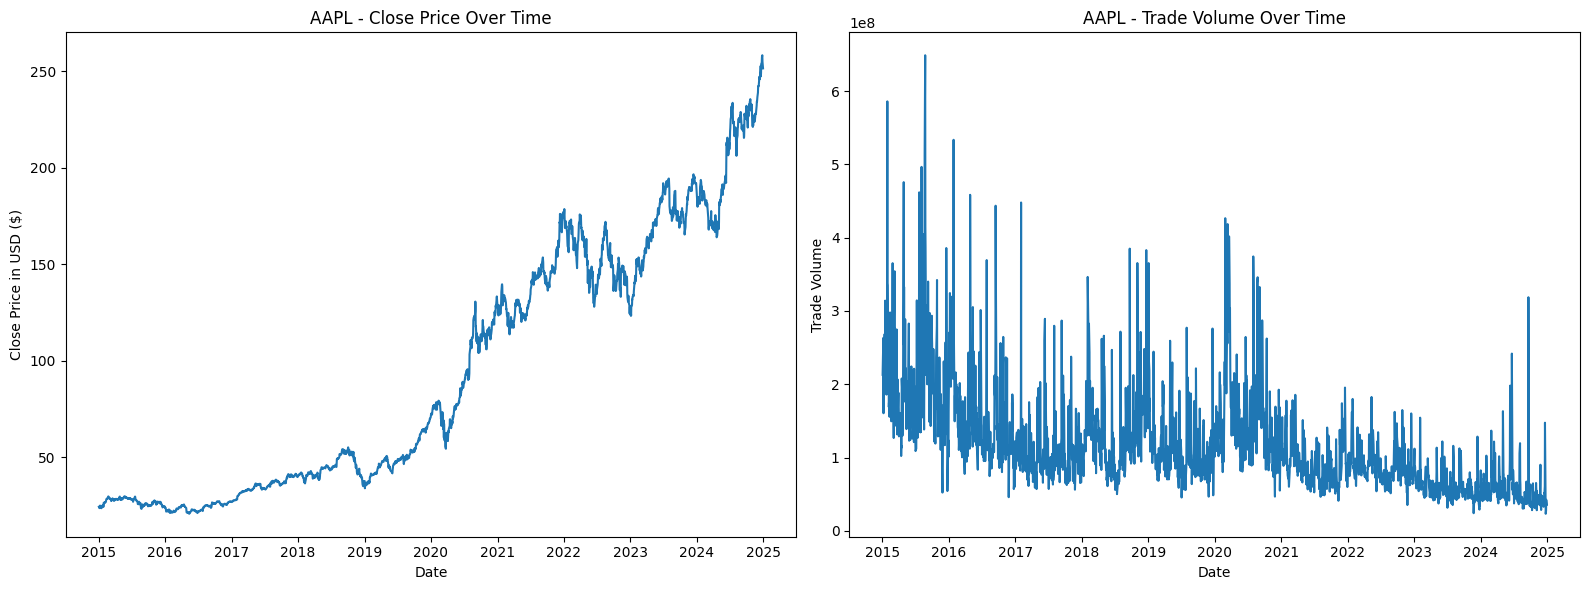

In [205]:
def plot_figures(df: pd.DataFrame, ticker: str) -> None:
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 6))
    axes = axes.flatten()

    # 1st plot
    sns.lineplot(df, ax=axes[0], x=df.index, y="Close")
    axes[0].set_title(f"{ticker} - Close Price Over Time")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Close Price in USD ($)")

    # 2nd plot
    sns.lineplot(df, ax=axes[1], x=df.index, y="Volume")
    axes[1].set_title(f"{ticker} - Trade Volume Over Time")
    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Trade Volume")

    plt.tight_layout()
    plt.show()


plot_figures(df, TICKER)


## 5. Sliding Window Sequences
The following function generates sliding window sequences and their corresponding targets from a multi-feature time-series array. This is a standard preprocessing step for models such as LSTM, GRU, or other neural networks that require sequence data as input.

<p align="center">
  <img src="https://www.researchgate.net/profile/Bernard-Benson/publication/341502672/figure/fig17/AS:998926190649344@1615173971540/Sliding-window-method-illustrated-with-an-example-sequence-of-numbers-from-1-through-10.ppm" width="550" alt="Sliding window method illustration">
</p>

*Figure: Visualisation of sliding window sequences. Image retrieved from [Forecasting Solar Cycle 25 Using Deep Neural Networks](https://www.researchgate.net/publication/341502672_Forecasting_Solar_Cycle_25_Using_Deep_Neural_Networks).*
